# Определяем гиперпараметры

In [4]:
BATCH_SIZE = 48
GAUSSIAN_NOISE = 0.1

# downsampling для препроцессинга
IMG_SCALING = (3, 3)
# количество изображений в валидационной выборке
VALID_IMG_COUNT = 900

MAX_TRAIN_STEPS = 200
MAX_TRAIN_EPOCHS = 30
AUGMENT_BRIGHTNESS = False

In [5]:
from keras.applications.resnet50 import ResNet50
from keras.regularizers import l1
import os
import numpy as np 
import pandas as pd
from skimage.io import imread, imshow  # читаем иозбражение
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap  ### получить цветовую карту
from skimage.segmentation import mark_boundaries  ### выделение границ
#from skimage.util import montage2d as montage  
from skimage.util.montage import montage2d as montage ## перевод любого размера массива в квадратную матрицу, 
###в нашем случае для того чтобы задать соотношение сторон фотки
from skimage.morphology import binary_opening, disk, label  # бинаризация изображения, 

### для предпоказа картинок
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1) # двигаем 1 измерение 
###на последнее место меняя местами соседов

## Папки с файлами картинок
#ship_dir = '../../Data'
ship_dir = '' ##current
train_image_dir = os.path.join(ship_dir, 'train/')
test_image_dir = os.path.join(ship_dir, 'test/')



############################# Блок функций по работе с масками    #########################################################
def multi_rle_encode(img, **kwargs):
    ##кодируем связанные области в виде раздельных масок. на вхд подаем изображение и получаем RLE формат для областей
    ## с одинаковым цветом. по сути несколько раз подавая на вход кодеру маски из 0 и 1 для каждой уникальной области

    ##labels = label(img)
    labels = img
    if img.ndim > 2:
        ## берем уникальные значения label, передаем в encode матрицу  h x w где каналы схлопнуты по сумме. получается 
        ## двумерный массив из 0 и сумм по каналам
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    Кодируем маску в формат RLE. Навход подаем img 2d из 0 и не 0
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten() ### вытягиваем изображение в одномерный вектор, читая его по строкам. 
    ##Берем первую строчку, первый столбце и вытаскиваем три канала, потом второй столбец
    pixels = np.concatenate([[0], pixels, [0]]) ## добавляем два нуля побокам
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1 ### вычисляем номера пикселей, где есть переход
    # от 0 к 1 - это будет граница
    runs[1::2] -= runs[::2] ## строим маску вычитаем: из номеров пикселей через один их соседей. 
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    Восстанавливаем маску размера shape по RLE
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T 

# ТАк как у нас в файле с масками разные корабли на одном изображении кодируются отдельной строкой,
# То нужна функция объеденяющая несколько масок в одну со всеми кораблями
def masks_as_image(in_mask_list):
    # Объеденим массив масок отдельных кораблей в один. т.е. если у нас для изображения несколько строк с масками
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask) ## битовый  or a = a | b
    return all_masks

def masks_as_color(in_mask_list):
    # создаем массив цветных масок для каждого корабля. Т.е. если несколько масок для картинки, то каждый корабль своим цветом
    # Первая маска будет под цифрой 1, вторая под цифрой 2 и т.д.
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2)
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

## Читаем файл с масками, смотрим статистику пустых

In [6]:
masks = pd.read_csv('train_ship_segmentations.csv',encoding= 'utf-8', delimiter=',')

## Убираем битые изображения
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images
e_l = pd.DataFrame(exclude_list, columns  = ['ImageId_y'])
x = pd.merge(masks,e_l,how = 'inner', suffixes=('_x','_y'),left_on='ImageId', right_on='ImageId_y')



masks = masks[masks.ImageId != '6384c3e78.jpg']
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

56030 masks in 29070 images
74999 empty images in 104069 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


## Проводим анализ данных

In [5]:
# Посмотрим сколько кораблей у нас есть на каждом изображении, размер файлов с изображениямии
# И отсечем "битые"

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
62791,9a4260c4e.jpg,1,1.0,[1.0],195.292969
46707,72cc5a970.jpg,0,0.0,[0.0],217.340820
39184,606de69bc.jpg,0,0.0,[0.0],99.175781
51456,7e75a6da2.jpg,1,1.0,[1.0],100.178711
47226,740ee4b2e.jpg,1,1.0,[1.0],121.298828
48558,7766771e5.jpg,1,1.0,[1.0],130.790039
49043,788ad911f.jpg,0,0.0,[0.0],125.467773


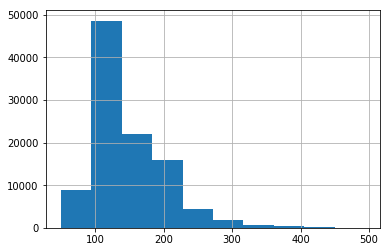

In [7]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
#unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] < 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

## Undersample "пустых" изображений
Делаем undersample пустых изображений, чтобы получить сбалансированные группы. Так как у нас намного больше изображений без кораблей. Оставляем всего порядка 11000 изображений. Что составляет примерно 10% от всего объема трейна

16000 masks


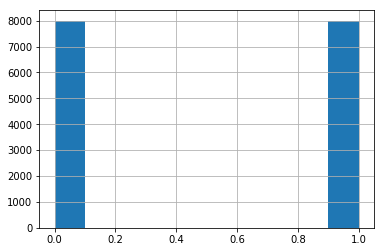

In [9]:
## Группируем по количеству кораблей, если в группе больше 2000 то берем рандомные 2000, если меньше то просто берем все
SAMPLES_PER_GROUP = 8000
balanced_train_df = unique_img_ids.groupby('has_ship').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['has_ship'].hist(bins=10)
print(balanced_train_df.shape[0], 'masks')

## Делим на трайн и валид со стратификацией по количеству кораблей на изображениях

In [10]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.3, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

16522 training masks
7081 validation masks


In [17]:
train_df.head()

,ImageId,EncodedPixels,ships,has_ship,has_ship_vec,file_size_kb
0,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,9,1.0,[1.0],242.910156
1,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,9,1.0,[1.0],242.910156
2,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,9,1.0,[1.0],242.910156
3,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...,9,1.0,[1.0],242.910156
4,00021ddc3.jpg,139644 2 140408 6 141174 9 141942 9 142711 6 1...,9,1.0,[1.0],242.910156


# Переводим все маски в изображения
Создаем под это дело генератор
upd 22.10 добавляем в генератор массив есть корабль. нет корабля, для ResNet

In [11]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId')) ## получаем список кортежей, где первый элемент - снимок, а второй описание
    out_rgb = []
    out_mask = []
    out_binary_mask = []
    while True:
        np.random.shuffle(all_batches) ## Перемешиваем набор
        for c_img_id, c_masks in all_batches: ##Берем наименование картинки и описание(в нем содержатся и маски)
            rgb_path = os.path.join(train_image_dir, c_img_id) ##Получаем путь картинки в папке
            c_has_ship = c_masks['has_ship'].max()
            c_img = imread(rgb_path) ##Читаем картинку
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)## Передаем в функцию массив масок ,
            # получаем массив 2d из 0 и 1. Добавляем в него 3 измерение. В итоге получаем rgb маску
            if IMG_SCALING is not None: # Ужимаем изображение в n раз
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            out_binary_mask +=[c_has_ship]
            
            if len(out_rgb)>=batch_size: # Когда количество картинок достигает размера бача
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0),np.stack(out_binary_mask,0)  ## Возращаем генератор картинок 
                out_binary_mask, out_rgb, out_mask=[], [], []

In [12]:
train_gen = make_image_gen(train_df) ## создаем генератор
train_x, train_y, train_y_binary = next(train_gen) ## Вызываем его первый раз
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())
print('y_bin', train_y_binary.shape, train_y_binary.min(), train_y_binary.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1
y_bin (48,) 0.0 1.0


In [14]:
###Получаем 4d массив, где первое измерение создержит картинку, а остальные три ее координаты

### Нарисуем, что получилось при создании бача

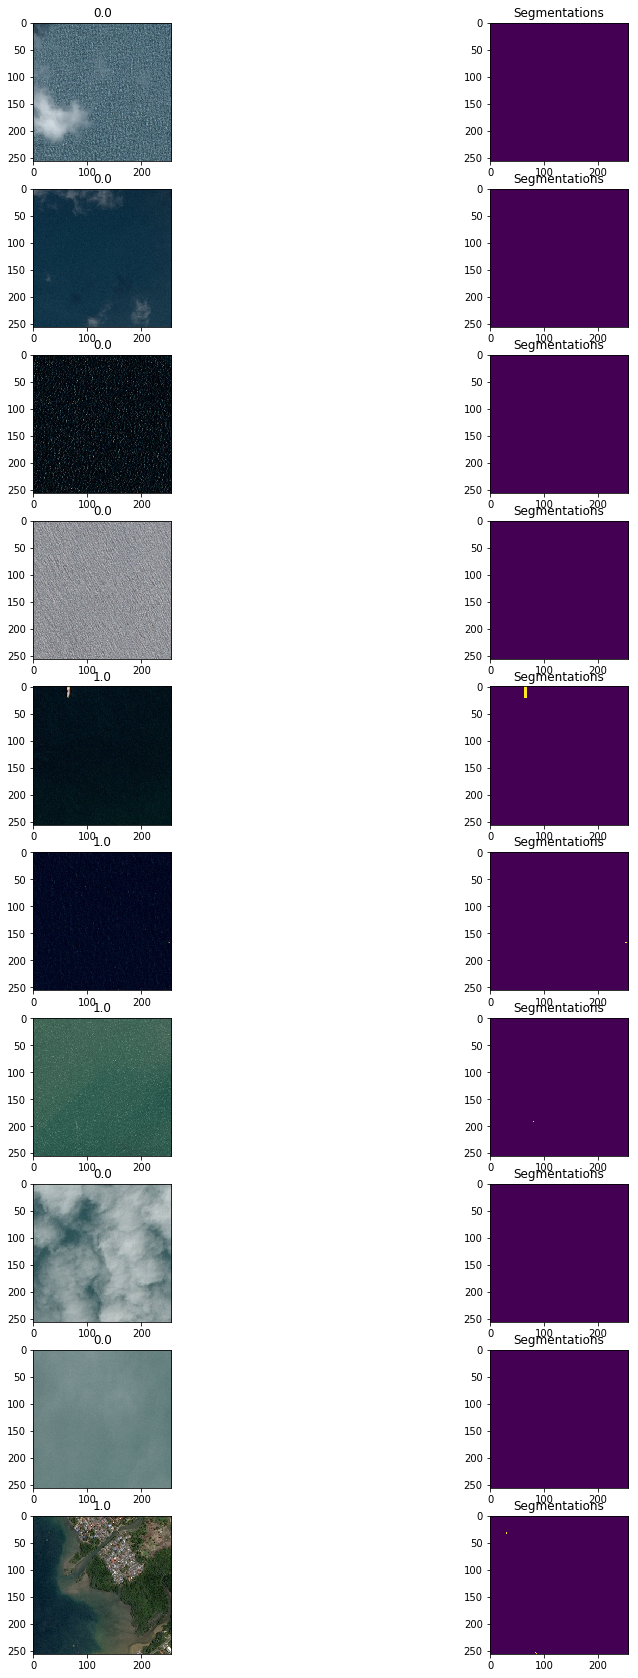

In [13]:

fig, m_axs = plt.subplots(10, 2, figsize = (15, 30))

for (ax1, ax2), x,y,z in zip(m_axs, train_x[15:25], train_y[15:25], train_y_binary[15:25]):

    ax1.imshow(x)
    ax1.set_title(''+ str(z))
  
    ax2.imshow(y.reshape(y.shape[0],y.shape[1]))
    ax2.set_title('Segmentations')
    

# Генерим валидационный набор

In [14]:
%%time
valid_x, valid_y, valid_y_bin = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape, valid_y_bin.shape)


(900, 256, 256, 3) (900, 256, 256, 1) (900,)
Wall time: 28.7 s


# Аугументация данных

In [17]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01, 
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, ## Переворачиваем по горизонтали
                  vertical_flip = True, ## Поворачиваем по вертикали
                  fill_mode = 'reflect', ###  как заполнять пустые зоны
                   data_format = 'channels_last')
if AUGMENT_BRIGHTNESS: ### делаем ли аугментацию яркости?
    dg_args['brightness_range'] = [0.5, 1.5] ### добавляем диапазон изменения яркости в словарь парметров
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range') ###  для масок удаляем яркость, так как там только один цвет
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    for in_x, in_y, in_y_bin in in_gen:

        seed = np.random.choice(range(9999))

        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x_y_bin = image_gen.flow(in_x,in_y_bin,
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        return zip(g_x_y_bin, g_y)

        ##yield next(g_x_y_bin), next(g_y)

In [67]:
?label_gen.flow()

## Посмотрим как работает аугументация. Вызываем генератор, смотрим на размеры данных.
### смотрим 9 картинок и масок

x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0
y_bin (48,) float64 0.0 1.0


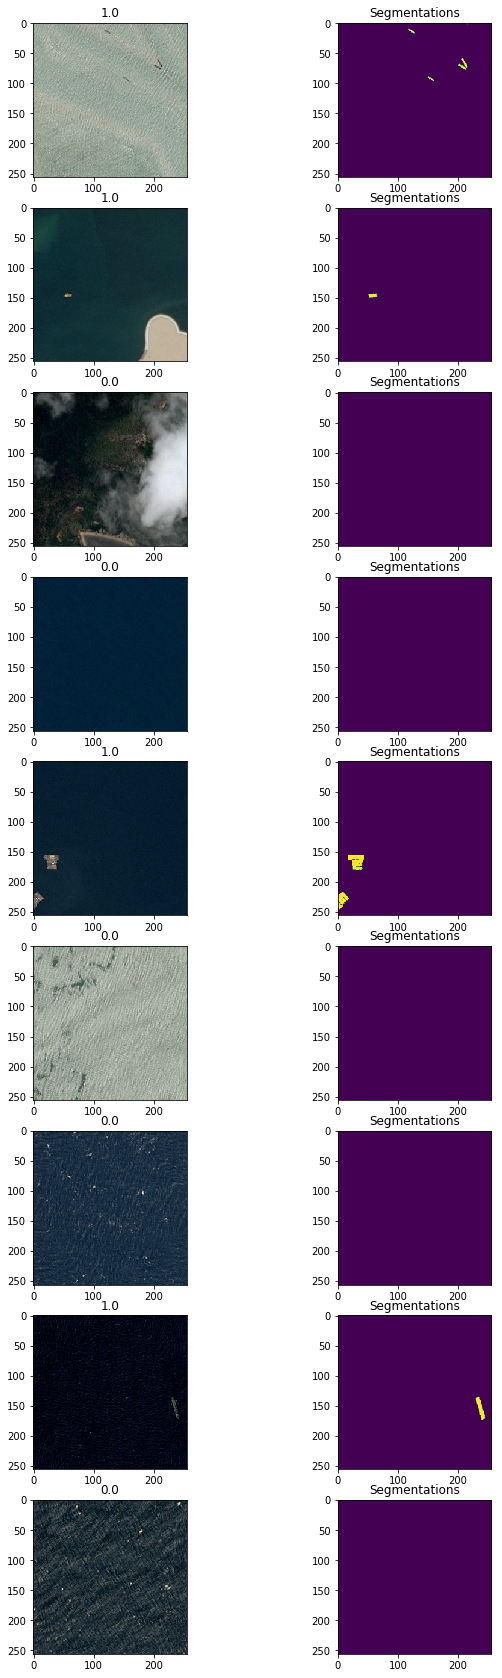

In [18]:
cur_gen = create_aug_gen(make_image_gen(train_df))
t_x_y_bin, t_y = next(cur_gen)

t_x = t_x_y_bin[0]
t_y_bin = t_x_y_bin[1]

print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
print('y_bin', t_y_bin.shape, t_y_bin.dtype, t_y_bin.min(), t_y_bin.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
t_y_bin = t_y_bin[:9]




fig, m_axs = plt.subplots(9, 2, figsize = (10, 30))

for (ax1, ax2), x,y,z in zip(m_axs, t_x, t_y,t_y_bin):

    ax1.imshow(x)
    ax1.set_title(''+ str(z))
  
    ax2.imshow(y.reshape(y.shape[0],y.shape[1]))
    ax2.set_title('Segmentations')
fig.savefig('overview2.png')

In [58]:
?enumerate()

In [65]:
for x,i in enumerate(base_model.layers):
    print (x, i.name )

0 input_3
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_99
5 max_pooling2d_3
6 res2a_branch2a
7 bn2a_branch2a
8 activation_100
9 res2a_branch2b
10 bn2a_branch2b
11 activation_101
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_33
17 activation_102
18 res2b_branch2a
19 bn2b_branch2a
20 activation_103
21 res2b_branch2b
22 bn2b_branch2b
23 activation_104
24 res2b_branch2c
25 bn2b_branch2c
26 add_34
27 activation_105
28 res2c_branch2a
29 bn2c_branch2a
30 activation_106
31 res2c_branch2b
32 bn2c_branch2b
33 activation_107
34 res2c_branch2c
35 bn2c_branch2c
36 add_35
37 activation_108
38 res3a_branch2a
39 bn3a_branch2a
40 activation_109
41 res3a_branch2b
42 bn3a_branch2b
43 activation_110
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 add_36
49 activation_111
50 res3b_branch2a
51 bn3b_branch2a
52 activation_112
53 res3b_branch2b
54 bn3b_branch2b
55 activation_113
56 res3b_branch2c
57 bn3b_branch2c
58 add_37
59 activation_114
60 res3c_branch2a


In [67]:
from keras import layers, models
base_model = ResNet50(weights='imagenet', include_top= False, input_shape= t_x.shape[1:],classes=2)
            # фиксируем все веса предобученной сети

for layer in base_model.layers[:168]:
    layer.trainable = False

o = base_model.output
o = layers.AveragePooling2D(pool_size=(8,8))(o)
o = layers.Flatten()(o)
o = layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=l1(1e-4))(o)
res =  models.Model(inputs=[base_model.input], outputs=[o])
res.summary()

res.compile(optimizer='SGD', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

res3a_branch2a (Conv2D)         (None, 32, 32, 128)  32896       activation_206[0][0]             
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 32, 32, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_207 (Activation)     (None, 32, 32, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 32, 32, 128)  147584      activation_207[0][0]             
__________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizati (None, 32, 32, 128)  512         res3a_branch2b[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
add_71 (Add)                    (None, 32, 32, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_215[0][0]             
__________________________________________________________________________________________________
activation_218 (Activation)     (None, 32, 32, 512)  0           add_71[0][0]                     
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 16, 16, 256)  131328      activation_218[0][0]             
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 16, 16, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_229 (Activation)     (None, 16, 16, 256)  0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 16, 16, 1024) 263168      activation_229[0][0]             
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 16, 16, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_75 (Add)                    (None, 16, 16, 1024) 0           bn4d_branch2c[0][0]              
                                                                 activation_227[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_240 (Activation)     (None, 8, 8, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 8, 8, 512)    2359808     activation_240[0][0]             
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 8, 8, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_241 (Activation)     (None, 8, 8, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 8, 8, 2048)   1050624     activation_241[0][0]             
__________

In [20]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('res_net')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

C:\Users\Python\Anaconda3\lib\site-packages\keras\callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [27]:
loss = res.fit_generator(create_aug_gen(make_image_gen(train_df)),
                             steps_per_epoch=200,
                             epochs=50,
                             validation_data=(valid_x,valid_y_bin),
                             callbacks=callbacks_list,
                             workers=1 
                                       )

Epoch 1/50
200/200 [==============================] - 191s 953ms/step - loss: 0.1098 - acc: 0.9705 - val_loss: 0.8021 - val_acc: 0.5033
Epoch 2/50


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_binary_crossentropy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `val_binary_crossentropy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_binary_crossentropy` which is not available. Available metrics are: val_loss,val_acc,loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


200/200 [==============================] - 135s 674ms/step - loss: 0.0236 - acc: 0.9997 - val_loss: 0.8722 - val_acc: 0.5033
Epoch 3/50
  1/200 [..............................] - ETA: 18s - loss: 0.0195 - acc: 1.0000

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `val_binary_crossentropy` which is not available. Available metrics are: val_loss,val_acc,loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


200/200 [==============================] - 137s 683ms/step - loss: 0.0174 - acc: 0.9999 - val_loss: 0.9558 - val_acc: 0.5033
Epoch 4/50
 53/200 [======>.......................] - ETA: 1:35 - loss: 0.0159 - acc: 1.0000

KeyboardInterrupt: 

In [21]:
weight_path="{}_weights.best.hdf5".format('res_net')
#res.save_weights(weight_path)
res.load_weights (weight_path)

## Визуализируем результаты обучения

In [22]:

def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
            [np.linspace(0.5, 1, len(loss_history.epoch)) ]))
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                loss_history.history['loss'],
                 'b-',
                 epich,loss_history.history['val_loss'], 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

   
    
    _ = ax2.plot(epich, 
        loss_history.history['binary_accuracy'] , 'b-',
                     epich,loss_history.history['val_binary_accuracy'] ,
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')
    
    _ = ax3.plot(epich,
        loss_history.history['true_positive_rate'] , 'b-',
                     epich,loss_history.history['val_true_positive_rate'] ,
                     'r-')
   
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('True Positive Rate\n(Positive Accuracy)')
    
    
    
    _ = ax4.plot(epich,
        loss_history.history['dice_coef'] , 'b-',
                     epich,loss_history.history['val_dice_coef'] ,
                     'r-')
    
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')




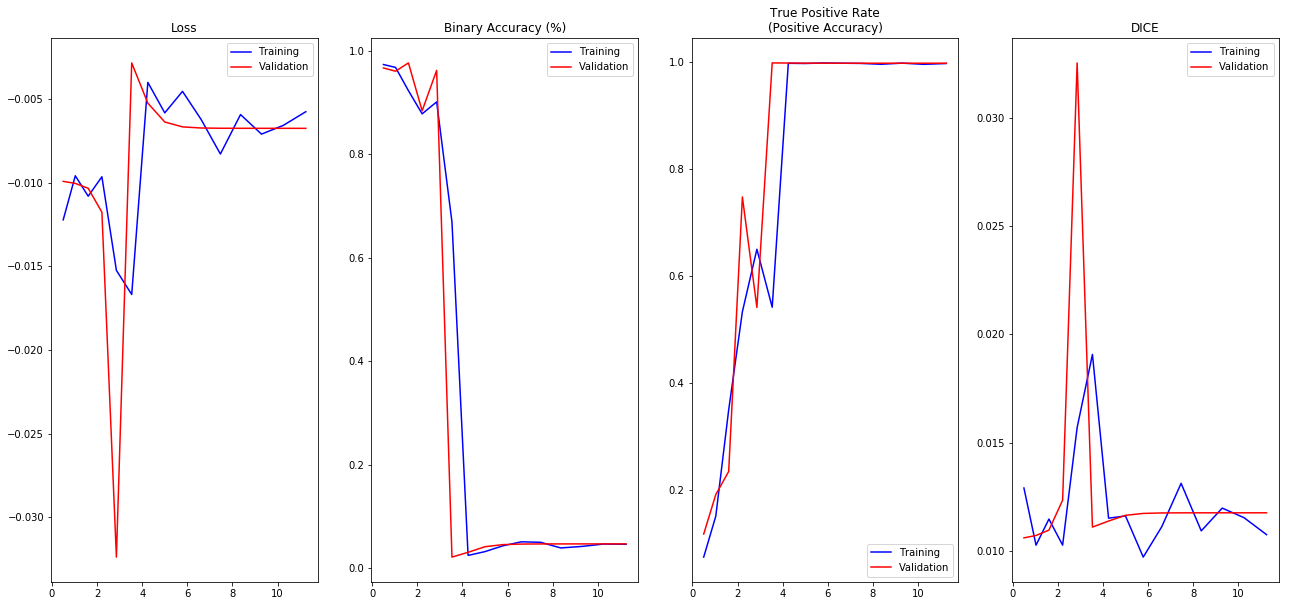

In [37]:
##Для ВАнильной модели
show_loss(loss_history_vanilla)

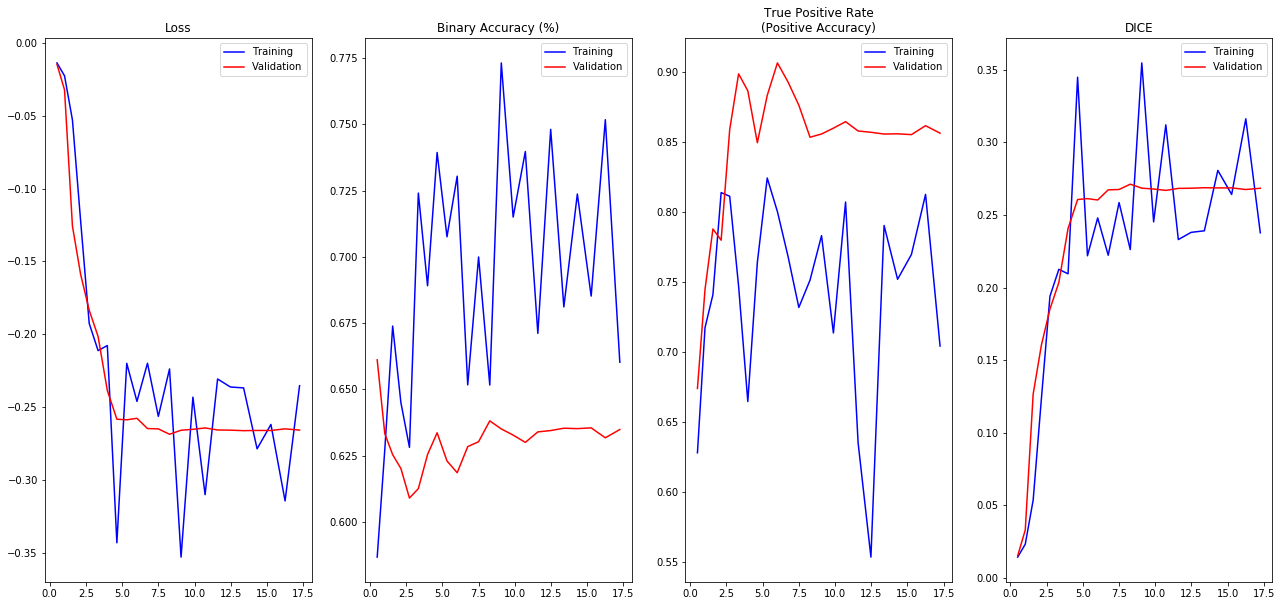

In [23]:
##Для тюнингованной модели
show_loss(loss_history_tun)

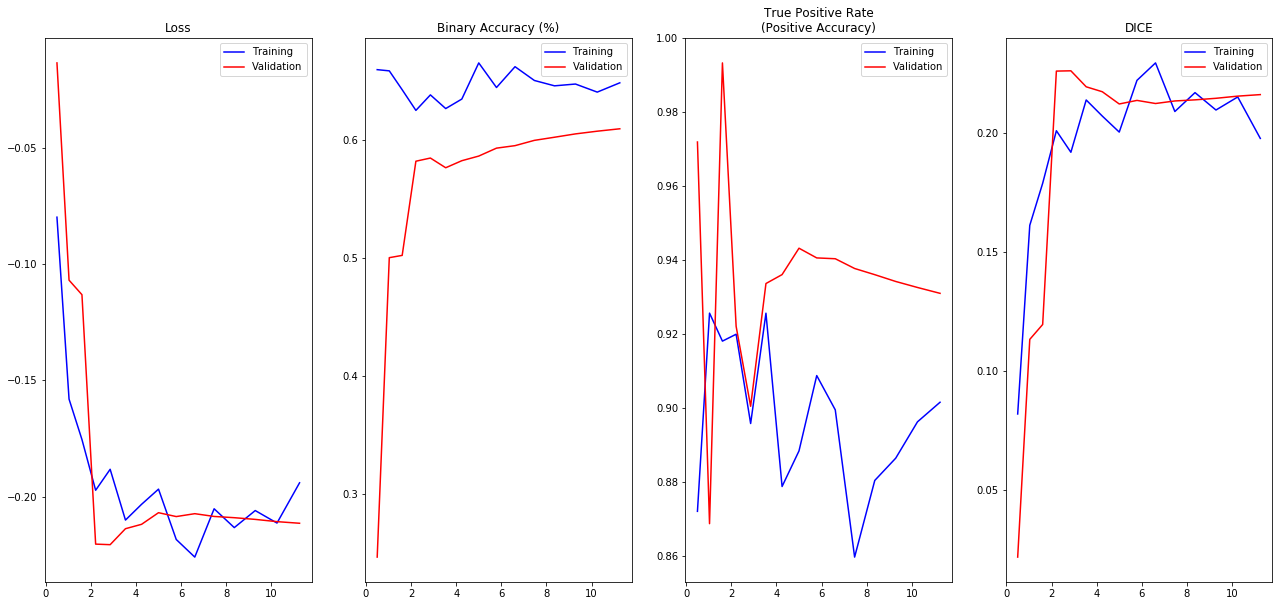

In [39]:
##Для тюнингованной модели
show_loss(loss_history_vgg)

## Делаем предсказания на валидационном наборе

In [35]:
valid_x.shape

(900, 256, 256, 3)

In [33]:
from tqdm import tqdm

In [50]:
predictions = []

for x  in tqdm(valid_x[:10]):
    print (x.shape)
    predictions+=res.predict(np.expand_dims(x,0))
    print  (res.predict(np.expand_dims(x,0)))    
                             
    

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

(256, 256, 3)
[[0.18530865]]


 10%|████████▎                                                                          | 1/10 [00:04<00:37,  4.16s/it]

(256, 256, 3)
[[0.18463297]]


 20%|████████████████▌                                                                  | 2/10 [00:08<00:33,  4.15s/it]

(256, 256, 3)
[[0.18857493]]


 30%|████████████████████████▉                                                          | 3/10 [00:12<00:29,  4.15s/it]

(256, 256, 3)
[[0.18815495]]


 40%|█████████████████████████████████▏                                                 | 4/10 [00:16<00:24,  4.16s/it]

(256, 256, 3)
[[0.1830231]]


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:20<00:20,  4.16s/it]

(256, 256, 3)
[[0.18433322]]


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:25<00:16,  4.18s/it]

(256, 256, 3)
[[0.18628936]]


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:29<00:12,  4.18s/it]

(256, 256, 3)
[[0.18856516]]


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:33<00:08,  4.18s/it]

(256, 256, 3)
[[0.18589555]]


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:37<00:04,  4.20s/it]

(256, 256, 3)
[[0.18740882]]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.20s/it]


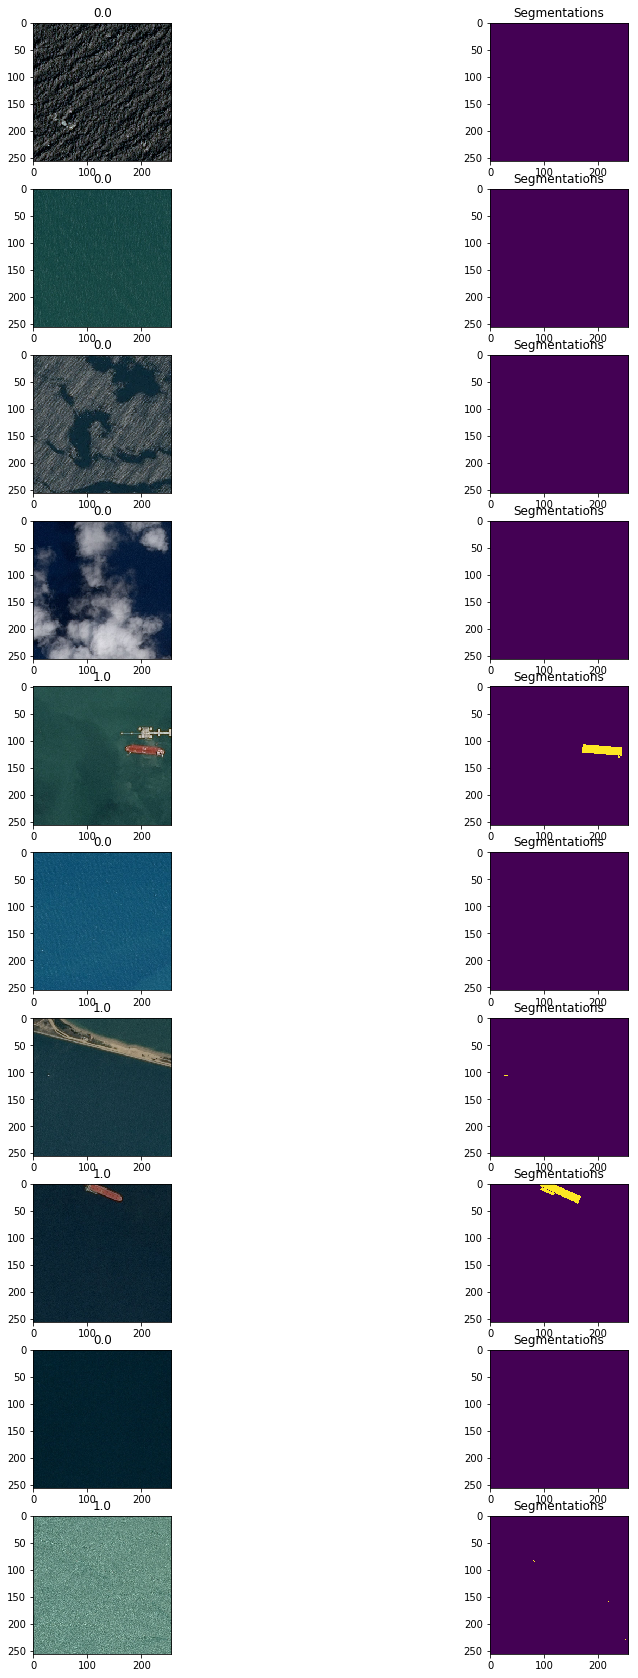

In [52]:

fig, m_axs = plt.subplots(10, 2, figsize = (15, 30))

for (ax1, ax2), x,y,z in zip(m_axs, valid_x[:10], valid_y[:10], valid_y_bin[:10]):

    ax1.imshow(x)
    ax1.set_title(''+ str(z))
  
    ax2.imshow(y.reshape(y.shape[0],y.shape[1]))
    ax2.set_title('Segmentations')

In [46]:
np.expand_dims(valid_x[0],0).shape

(1, 256, 256, 3)

In [23]:
pred_y = res.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

KeyboardInterrupt: 

## Посмотрим, распределение предсказаний

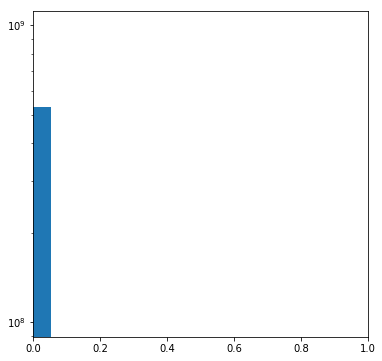

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

# Визуализируем предсказания

NameError: name 'seg_w_tun' is not defined

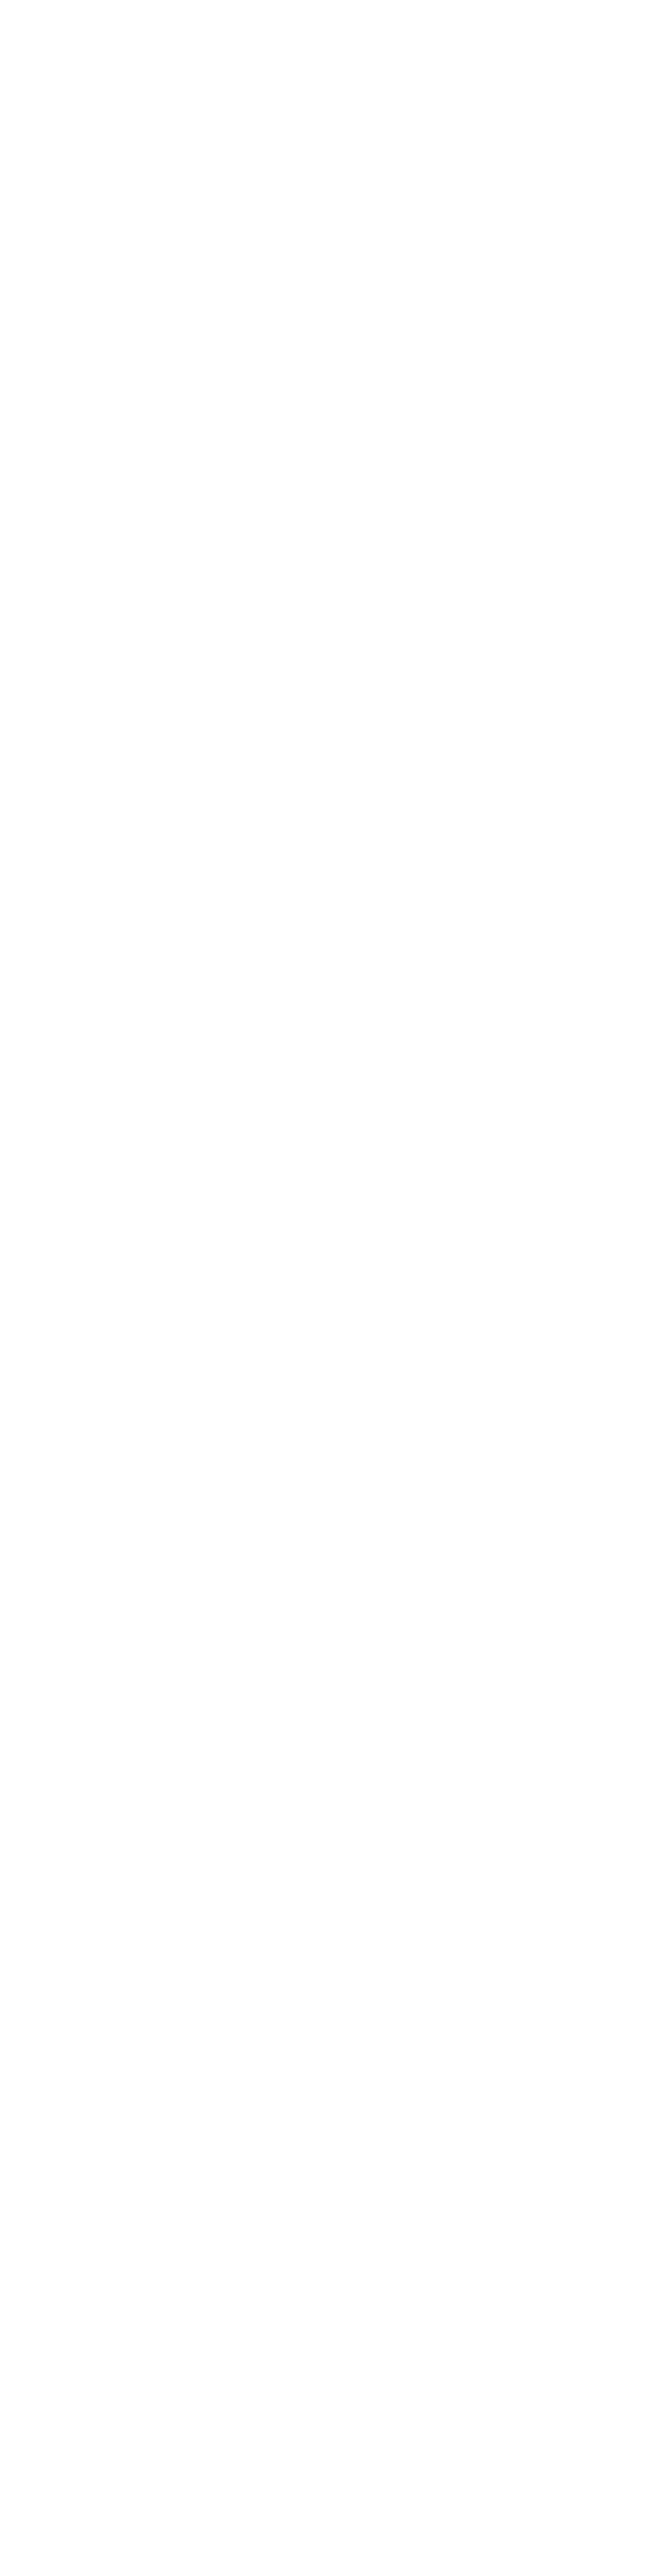

In [22]:
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = seg_w_tun.Predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')

# Сабмит

#### СМотрим сколько у нас изображений получилось в тесте

In [29]:
test_paths = np.array(os.listdir(test_image_dir))
print(len(test_paths), 'test images found')

15606 test images found


## Создаем массив предсказаний

In [32]:
from tqdm import tqdm_notebook
 
def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths): 
    out_pred_rows += pred_encode(c_img_name, min_max_threshold=1.0) ###создаем двумерный массив: изображение/маска

## Переводим массив в pandas df, убираем нули

In [33]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]
sub.head()

,ImageId,EncodedPixels
0,681b3af6a.jpg,773 317 1091 18 1113 422 1540 338 1879 425 230...
1,3ce74f9b3.jpg,772 413 1188 19 1293 60 1384 14 1399 1 1403 13...
2,a43731c17.jpg,849 27 952 19 999 24 1250 60 1616 29 1719 21 1...
3,c83c9a39b.jpg,519635 1 519637 1 520402 5 521169 7 521937 8 5...
4,83178d800.jpg,772 111 894 10 1539 113 1661 12 2306 116 2428 ...


## Пишем в файл

In [36]:
sub1 = pd.read_csv(os.path.join(ship_dir, 'sample_submission_v2.csv'))
sub1 = pd.DataFrame(np.setdiff1d(sub1['ImageId'].unique(), sub['ImageId'].unique(), assume_unique=True), columns=['ImageId'])
sub1['EncodedPixels'] = None
print(len(sub1), len(sub))

sub = pd.concat([sub, sub1])
print(len(sub))
sub.to_csv('submission.csv', index=False)
sub.head()

8532 7074
15606


,ImageId,EncodedPixels
0,681b3af6a.jpg,773 317 1091 18 1113 422 1540 338 1879 425 230...
1,3ce74f9b3.jpg,772 413 1188 19 1293 60 1384 14 1399 1 1403 13...
2,a43731c17.jpg,849 27 952 19 999 24 1250 60 1616 29 1719 21 1...
3,c83c9a39b.jpg,519635 1 519637 1 520402 5 521169 7 521937 8 5...
4,83178d800.jpg,772 111 894 10 1539 113 1661 12 2306 116 2428 ...
